## **Regression with a Mohs Hardness**



In [1]:
import math
from scipy import stats 
import numpy as np 
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn import tree 
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.optimizers import RMSprop

## Explorating Data Analysis (EDA)


allectrons_Total - The total number of electrons in the atomic structure of the material. 

density_Total - The total density of a material. The total density would typically be a measure of mass per unit volume for the entire material. 

allelectrons_Average - The average number of electrons in the atomic structure of a material. 

val_e_Average - The average number of valence electrons in the atomic structure of a material. In the context of materials science, valence electrons are the electrons in the outermost shell of an atom and are crusial in determning the element's chemical properties.

atomicweight_Average - The average atomic weight of the elements within the atomic structure of a material. The atomic weight is the weighted average mass of the atoms in a naturally occuring sampe of an element. It takes into account the abundance of isotopes and their respective masses.

ionenergy_Average - The average ionization energy of the atoms within the atomic structure of a material. Ionization enegery is the energy required to remove an electron from an atom, turning it into a positively charged ion.

el_neg_chi_Average - The average Pauling electronegativity of the most common oxidation state of the elements within the atomic structute of a material. Pauling electronegativity is a measure of the tendency of an atom to attract a bonding pair of electrons in a chemical compound.

R_vdw_element_Average - The average van der Waals radius of the elements within the atomc structure of a material. Van der Waals radius is a measure of the size of an atom, representing the distance between the nuclei of two adjacent atoms when they are barely touching.

R_cov_element_Average - The average covalent radius of the elements within the atomic structure of a material. Covalent radius is a measure of the size of an atom, specifically related to the distance between the nuclei of two bonded atoms when they are sharing an electron pair in a covalent bond.

zaratio_Average - The elements with atomic number "Z", where "Z" is a common symbol for atomic number. It might mean the average value of a particular ratio related to atomic numbers.

Density_Average - The average density of a material and is likely a feature or descriptor in a dataset related to materials science. Density is a fundamental property of materials, representing the mass per unit volume.

Hardness - Mohs Hardness Scale. This scale characterizes the scratch resistance of minerals. It is a qualitatice scale ranging from 1 to 10.


In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')
submission = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')

In [3]:
def summary_descriptive_statistics(df):
    
    print(f'\nData shape: {df.shape} included column id.\n') 
    print(100*"-")
    
    df = df.drop('id' , axis=1)
    
    num_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()
    
    duplicate_count = df.duplicated().sum()
    
    print(f'\nContinous: {num_cols} \n')
    
    print(f"\nCategorie: {cat_cols} \n")
    
    print(f"\nThere are {duplicate_count} duplicates \n")
    print(100*"-")
    
    print("\nTable of summary: \n")
    summ = pd.DataFrame(df.dtypes, columns=['datatype'])
    
    summ['#missing'] = df.isnull().sum().values 
    
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    
    summ['#unique'] = df.nunique().values
    
    desc = pd.DataFrame(df.describe(include='all').transpose())
    
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['mean'] = desc['mean'].values
    summ['std'] = desc['std'].values
    summ['median'] = df.median()
    summ['1st quantiel'] = df.quantile(0.25)
    summ['3st quantiel'] = df.quantile(0.75)
    
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    summ['last value'] = df.loc[len(df)-1].values
    
    return summ


def categorie_or_continous(df):
    
    cat_cols = []
    num_cols = []

    for col in df.columns:
        if df[col].nunique() <= 30:
            cat_cols.append(col)
        elif df[col].dtype in ['float64', 'int64']:
            num_cols.append(col)
        else:
            cat_cols.append(col)
    
    print(f"Categorical variable: {cat_cols} \n")
    
    print(f"Continuous variable: {num_cols} \n")
    
    return num_cols, cat_cols


def boxplot(df,width=15,length=15):
    
    plt.figure(figsize=(width, length))
    
    z = 1
    
    if len(df.columns.tolist()) % 2 == 0:
        
        if len(df.columns.tolist()) / 4 >= 1:
            y = math.ceil(len(df.columns.tolist())/ 4)
            for x in df.columns.tolist():
                plt.subplot(y, 4, z)
                plt.boxplot(df[x])
                plt.title(f"Boxplot of {df.columns.tolist()[z-1]}")
                z += 1
                
        else:
            y = math.ceil(len(df.columns.tolist())/ 2)
            for x in df.columns.tolist():
                plt.subplot(y, 2, z)
                plt.boxplot(df[x])
                plt.title(f"Boxplot of {df.columns.tolist()[z-1]}")
                z =+ 1
                
    else:
        y = math.ceil(len(df.columns.tolist())/ 3)
        for x in df.columns.tolist():
            plt.subplot(y, 3, z)
            plt.boxplot(df[x])
            plt.title(f"Boxplot of {df.columns.tolist()[z-1]}")
            z += 1
            
    plt.show()

def remove_outliers(df, column, threshold=1.5, z_threshold=4):
    
    Q1 = df[column].quantile(0.1)
    Q3 = df[column].quantile(0.9)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR
    
    z_scores = np.abs(stats.zscore(df[column]))
    
    clean_df_iqr = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    clean_df_z = df[(z_scores <= z_threshold)]
        
    return pd.concat([clean_df_iqr,clean_df_z]).drop_duplicates().reset_index(drop=True)

def histogram(df, width=20, length=10):
    plt.figure(figsize=(width, length))
    z = 1
    if len(df.columns.tolist()) % 2 == 0:
        if len(df.columns.tolist()) / 4 >= 1:
            y = math.ceil(len(df.columns.tolist())/ 4)
            for x in df.columns.tolist():
                plt.subplot(y, 4, z)
                sns.histplot(df[x],kde=True)
                plt.title(f"Histogram of {df.columns.tolist()[z-1]}")
                z += 1
        else:
            y = math.ceil(len(df.columns.tolist())/ 2)
            for x in df.columns.tolist():
                plt.subplot(y, 2, z)
                sns.histplot(df[x], kde=True)
                plt.title(f"Histogram of {df.columns.tolist()[z-1]}")
                z += 1
    elif len(df.columns.tolist()) == 1:
        for x in df.columns.tolist():
            plt.figure(figsize=(width, length))
            sns.histplot(df[x], kde=True)
            plt.title(f"Histogram of {df.columns.tolist()[0]}")
    else:
        y = math.ceil(len(df.columns.tolist())/ 3)
        for x in df.columns.tolist():
            plt.subplot(y, 3, z)
            sns.histplot(df[x], kde=True)
            plt.title(f"Histogram of {df.columns.tolist()[z-1]}")
            z += 1
    plt.show()

def skew_with_log(df, width, length):
    
    y = math.ceil(len(df.columns.tolist())/ 2)
    for x in df.columns.tolist():
        plt.figure(figsize=(width, length))
        plt.subplot(y,2,1)
        plt.title("Before", fontsize=15)
        sns.histplot(df[x], kde=True, color="red")
        
        log_tr = np.log(df[x] + 1)
        plt.subplot(y,2,2)
        plt.title("After", fontsize=15)
        sns.histplot(log_tr, kde=True , legend=False)
        
        plt.xlabel(x)
        
        plt.show()

def correlation(df, width=6, length=6):
    plt.figure(figsize=(width, length))
    mask = np.triu(np.ones_like(df.corr()))
    heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap.set_title('Correlation Heatmap');
    
def result_bar_plt(df):
    
    df = df.map({0: False, 1: True})
    
    value_counts = df.value_counts()
    true_count = value_counts[True] if True in value_counts else 0
    false_count = value_counts[False] if False in value_counts else 0

    plt.bar(['True', 'False'], [true_count, false_count])

    plt.xlabel('Boolean Values')
    plt.ylabel('Count')
    plt.title('Boolean Value Histogram')

    plt.show()
    
def scatterplot(df, forecast_value, width=20, length=10):
    plt.figure(figsize=(width, length))
    z = 1
    a = len(df.columns.tolist())

    if len(df.columns.tolist()) % 2 == 0:
        if len(df.columns.tolist()) / 4 >= 1:
            y = math.ceil(len(df.columns.tolist())/ 4)
            for x in df.columns.tolist():
                plt.subplot(y, 4, z)
                plt.scatter(y = df[x], x = forecast_value)
                plt.title(f"Scatterplot of {df.columns.tolist()[z-1]}")
                z += 1
                
        else:
            y = math.ceil(len(df.columns.tolist())/ 2)
            for x in df.columns.tolist():
                plt.subplot(y, 2, z)
                plt.scatter(y = df[x], x = forecast_value)
                plt.title(f"Scatterplot of {df.columns.tolist()[z-1]}")
                z += 1
                
    elif len(df.columns.tolist()) == 1:
        plt.figure(figsize=(6, 6))
        plt.scatter(y = df[x], x = forecast_value)
        plt.title(f"Scatterplot of {df.columns.tolist()[0]}")
        
    else:
        
        y = math.ceil(len(df.columns.tolist())/ 3)
        for x in df.columns.tolist():
            plt.subplot(y, 3, z)
            plt.scatter(y = df[x], x = forecast_value)
            plt.title(f"Scatterplot of {df.columns.tolist()[z-1]}")
            z += 1
            
    plt.show()
    
def model_evaluation(y_test,y_pred):
    plt.figure(figsize=(7,5))
    sns.regplot(x=y_test,y=y_pred,color="red",line_kws={'linewidth': 3},scatter=False)
    sns.scatterplot(x=y_test, y=y_pred,color="olive",marker="v",s=80)

    plt.show()

In [4]:
train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [5]:
summary_descriptive_statistics(train)


Data shape: (10407, 13) included column id.

----------------------------------------------------------------------------------------------------

Continous: ['allelectrons_Total', 'density_Total', 'allelectrons_Average', 'val_e_Average', 'atomicweight_Average', 'ionenergy_Average', 'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average', 'zaratio_Average', 'density_Average', 'Hardness'] 


Categorie: [] 


There are 0 duplicates 

----------------------------------------------------------------------------------------------------

Table of summary: 



,datatype,#missing,%missing,#unique,min,max,mean,std,median,1st quantiel,3st quantiel,first value,second value,third value,last value
allelectrons_Total,float64,0,0.0,325,0.0,15300.000000,128.053516,224.123776,100.000000,68.000000,131.000000,100.000000,100.000000,76.000000,288.000000
density_Total,float64,0,0.0,1099,0.0,643.093804,14.491342,15.972877,10.650000,7.558488,16.676996,0.841611,7.558488,8.885992,24.655328
allelectrons_Average,float64,0,0.0,629,0.0,67.000000,17.033222,10.468734,12.600000,10.000000,22.000000,10.000000,10.000000,15.600000,11.142857
val_e_Average,float64,0,0.0,205,0.0,6.000000,4.546789,0.690864,4.714286,4.000000,4.800000,4.800000,4.800000,5.600000,4.571429
atomicweight_Average,float64,0,0.0,849,0.0,167.400000,37.507703,26.012313,26.203827,20.298893,48.719500,20.612526,20.298893,33.739258,22.536126
ionenergy_Average,float64,0,0.0,898,0.0,15.245810,10.938308,1.408276,11.202760,10.590660,11.670725,11.088100,12.040830,12.086300,10.960357
el_neg_chi_Average,float64,0,0.0,745,0.0,3.443000,2.607662,0.334906,2.706000,2.530000,2.805000,2.766000,2.755000,2.828000,2.792143
R_vdw_element_Average,float64,0,0.0,737,0.0,2.250000,1.731330,0.192481,1.732727,1.672500,1.800000,1.732000,1.631000,1.788000,1.772857
R_cov_element_Average,float64,0,0.0,698,0.0,1.615840,0.944132,0.180017,0.915556,0.864000,0.981667,0.860000,0.910000,0.864000,0.940000
zaratio_Average,float64,0,0.0,815,0.0,0.825990,0.493349,0.063080,0.488550,0.476196,0.496070,0.496070,0.492719,0.481478,0.493919


**Based on the information, here are some observations and potential conclusions:**

There are no missing values in any of the columns, as indicated by the "#missing" and "%missing values being 0 for all columns. This is beneficial for data analysis, as complete data sets are often easier to work with. All columns have a data type of "float64", indicating that they contain numerical data. Some columns, such as "allelectorns_Total", "density_Total" and "ionenergy_Average", exhibits a wide range of values. The standard deviation for certain columns, such as "ionenergy_Avergae" and "atomicweight_Avergae" is relatively high. This suggests that the values in these columns are dispersed or spread out from the mean, indicating variability in these properties. The "Hardness" predictive column has a limited range (from 1.0 to 10.0). Given the wide range of values, it might be worth checking for potential outliers in certain columns. Outliers can signifcantly impact statistical analyses and may warrent closer examination.

In [6]:
summary_descriptive_statistics(test)


Data shape: (6939, 12) included column id.

----------------------------------------------------------------------------------------------------

Continous: ['allelectrons_Total', 'density_Total', 'allelectrons_Average', 'val_e_Average', 'atomicweight_Average', 'ionenergy_Average', 'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average', 'zaratio_Average', 'density_Average'] 


Categorie: [] 


There are 0 duplicates 

----------------------------------------------------------------------------------------------------

Table of summary: 



,datatype,#missing,%missing,#unique,min,max,mean,std,median,1st quantiel,3st quantiel,first value,second value,third value,last value
allelectrons_Total,float64,0,0.0,263,0.0,10116.000000,126.460128,207.564499,100.000000,68.000000,128.000000,884.000000,90.000000,116.000000,134.000000
density_Total,float64,0,0.0,904,0.0,643.093804,14.794020,18.982447,10.650000,7.558488,16.601328,121.420000,9.931960,7.767992,17.590000
allelectrons_Average,float64,0,0.0,514,0.0,67.000000,17.406186,10.996089,12.666667,10.000000,22.000000,35.360000,18.000000,11.600000,67.000000
val_e_Average,float64,0,0.0,185,0.0,6.000000,4.546852,0.683158,4.750000,4.000000,4.800000,5.280000,5.600000,4.800000,5.000000
atomicweight_Average,float64,0,0.0,728,0.0,167.400000,38.422790,27.344351,26.203827,20.298893,48.719500,82.561240,39.568056,23.231818,167.400000
ionenergy_Average,float64,0,0.0,699,0.0,15.245810,10.921512,1.378980,11.202760,10.584314,11.645560,9.370384,12.086300,11.023840,8.213150
el_neg_chi_Average,float64,0,0.0,643,0.0,3.443000,2.608119,0.322873,2.706000,2.527500,2.806667,2.298000,2.868000,2.644000,1.950000
R_vdw_element_Average,float64,0,0.0,622,0.0,2.250000,1.737907,0.190584,1.736000,1.678000,1.820000,1.907200,1.652000,1.794000,2.040000
R_cov_element_Average,float64,0,0.0,592,0.0,1.615333,0.949638,0.179266,0.920000,0.866667,0.990000,1.200000,0.864000,0.960000,1.410000
zaratio_Average,float64,0,0.0,660,0.0,0.825990,0.491675,0.060829,0.488550,0.476095,0.496118,0.461899,0.476196,0.499514,0.401635


**Now let's analyze the two tables to identify patterns and differences:**

Both tables have the same set of features. The number of missing values for each features is zero in both tables. For most features, the minimum, maximum, mean, standard deviation, median, and quantiles are quite close between the training set and test set. This suggests that the distributions of these features are similar in both datasets (There is one thing, if u see at allelectrons_Total the max from the trainigset is quite hugh with testset) --> I think that there are outliers! The mean and media values are close for most the features, suggesting that the distributions are relatively symmetric. However, for some features, there might be slight skewness, as the mean and median differ slightly. 

In [7]:
# Cleaning test and trainset 1
test = test.drop(columns = "id")

train = train.drop(columns = "id")

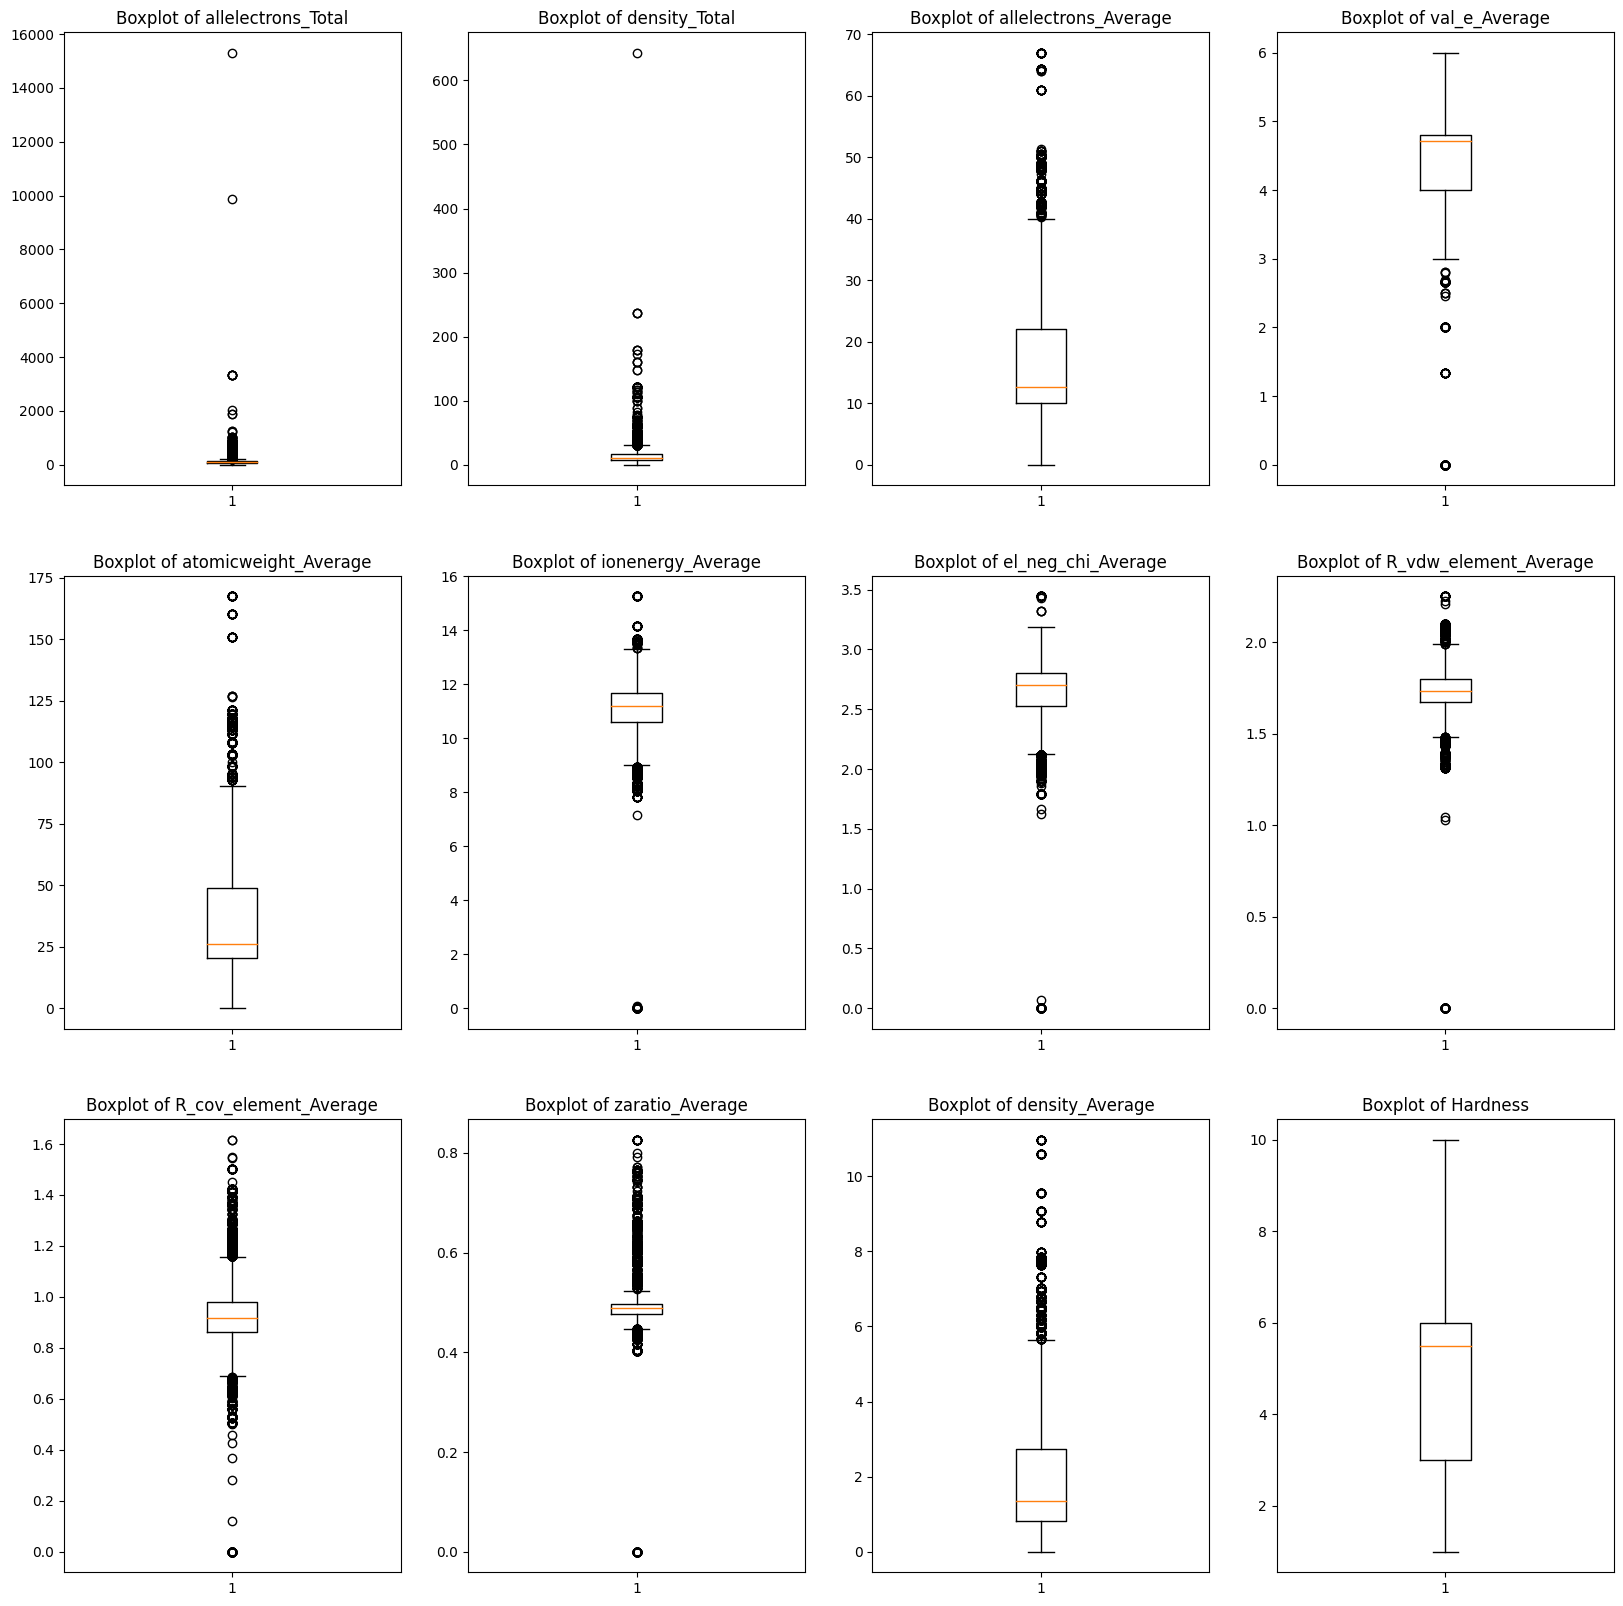

In [8]:
boxplot(train, width = 20, length = 20)

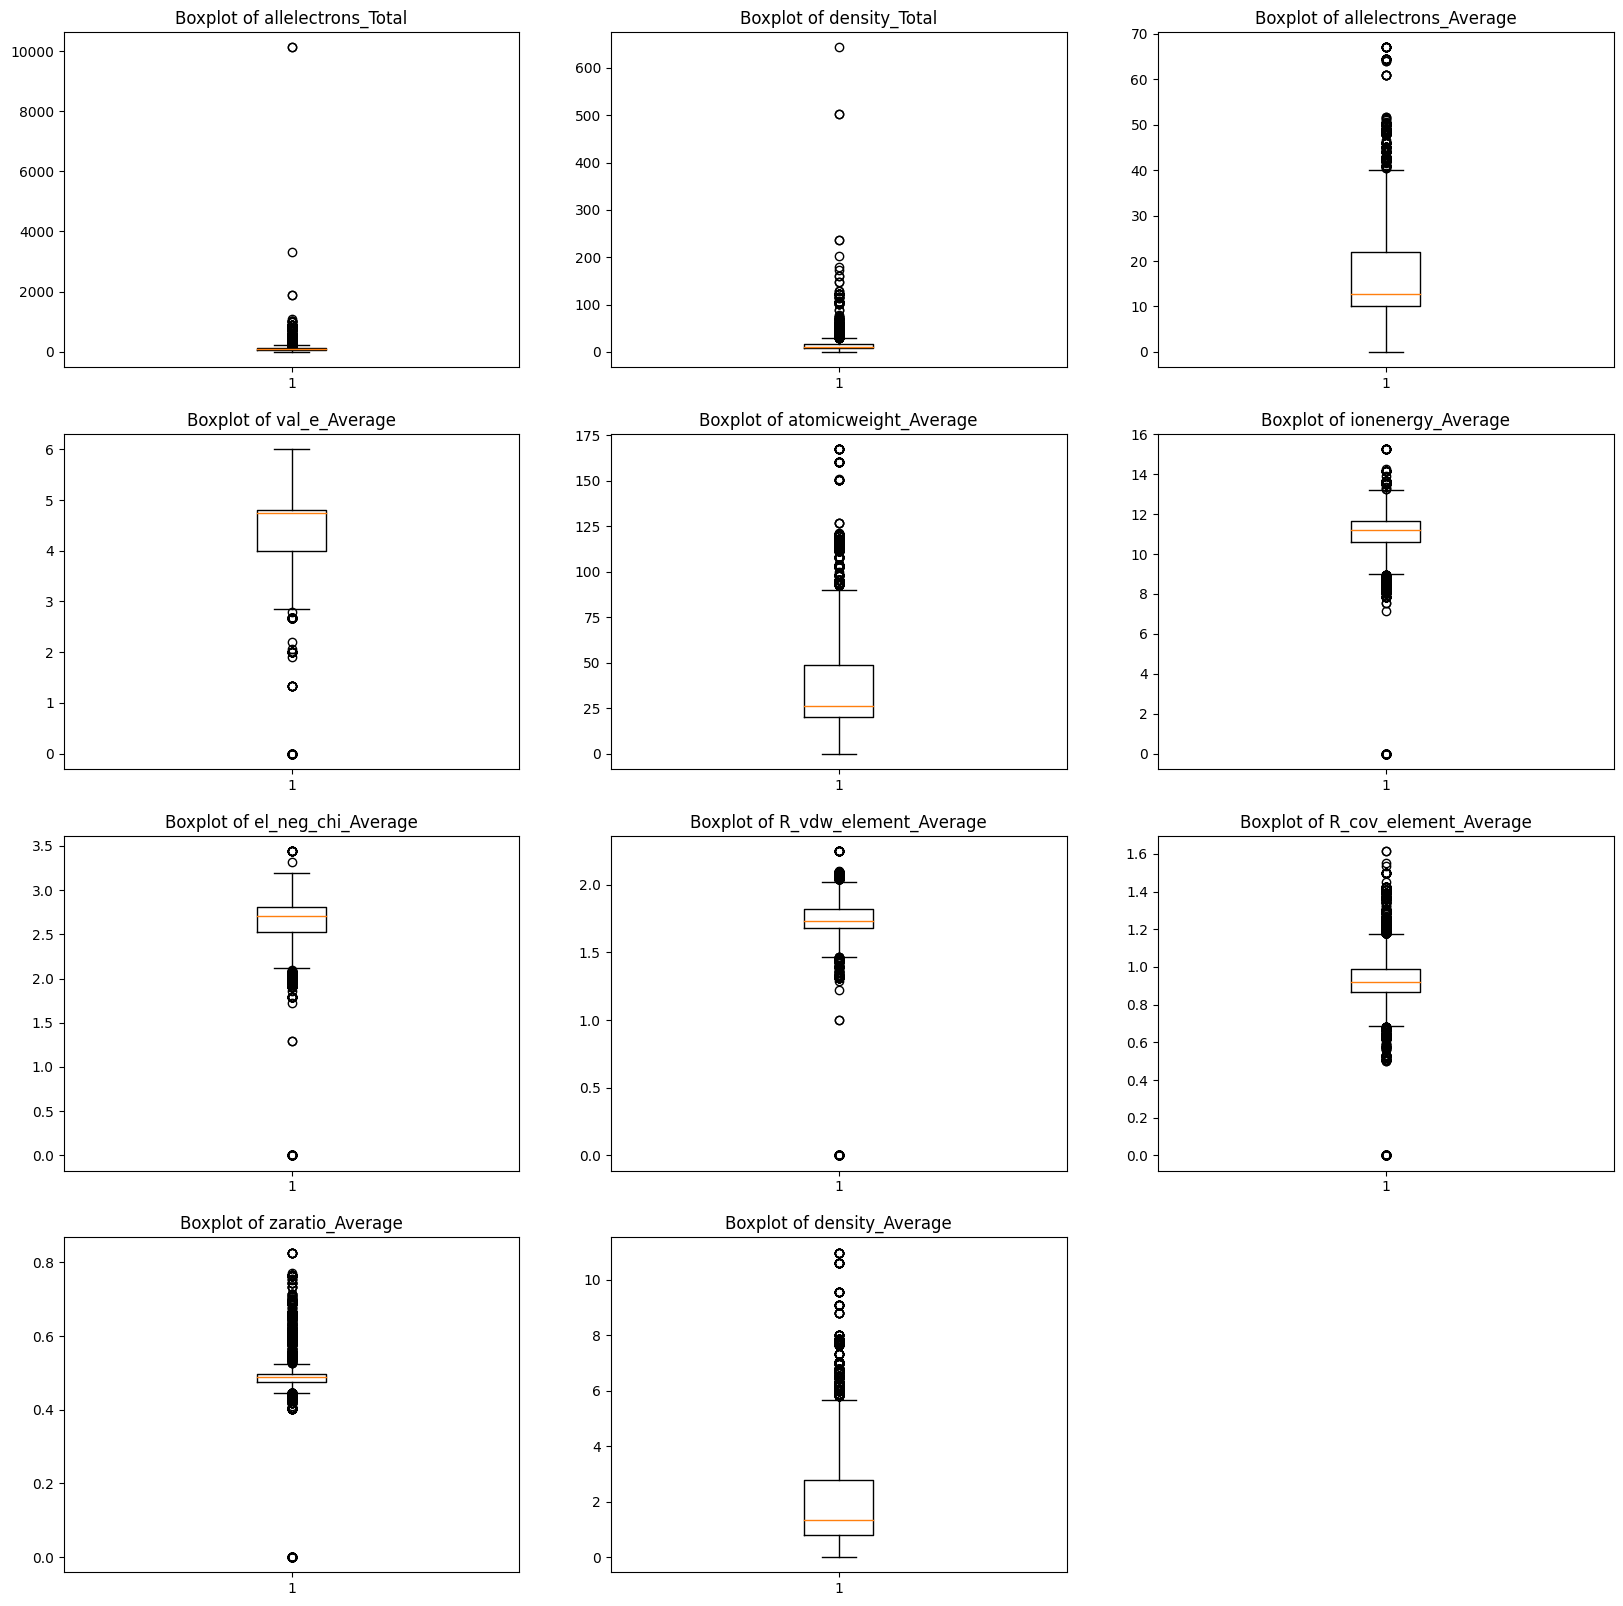

In [9]:
boxplot(test, width = 20, length = 20)

It's advisable to remove outliers only when there's valid justification. Certain outliers are a part of the natural variability within the population and should be retained in the dataset. These are authentic outliers. However, there are outliers that pose issues and shoud be excluded from the dataset. These could be error in the measurement, input, or processing, or datafrom a non-representative-sample. There is now one row that need to be removed and that is with allelectrons_Total 15300.

In [10]:
# Cleaning trainset 2
train = train.drop(train[train.allelectrons_Total >= 10116].index)

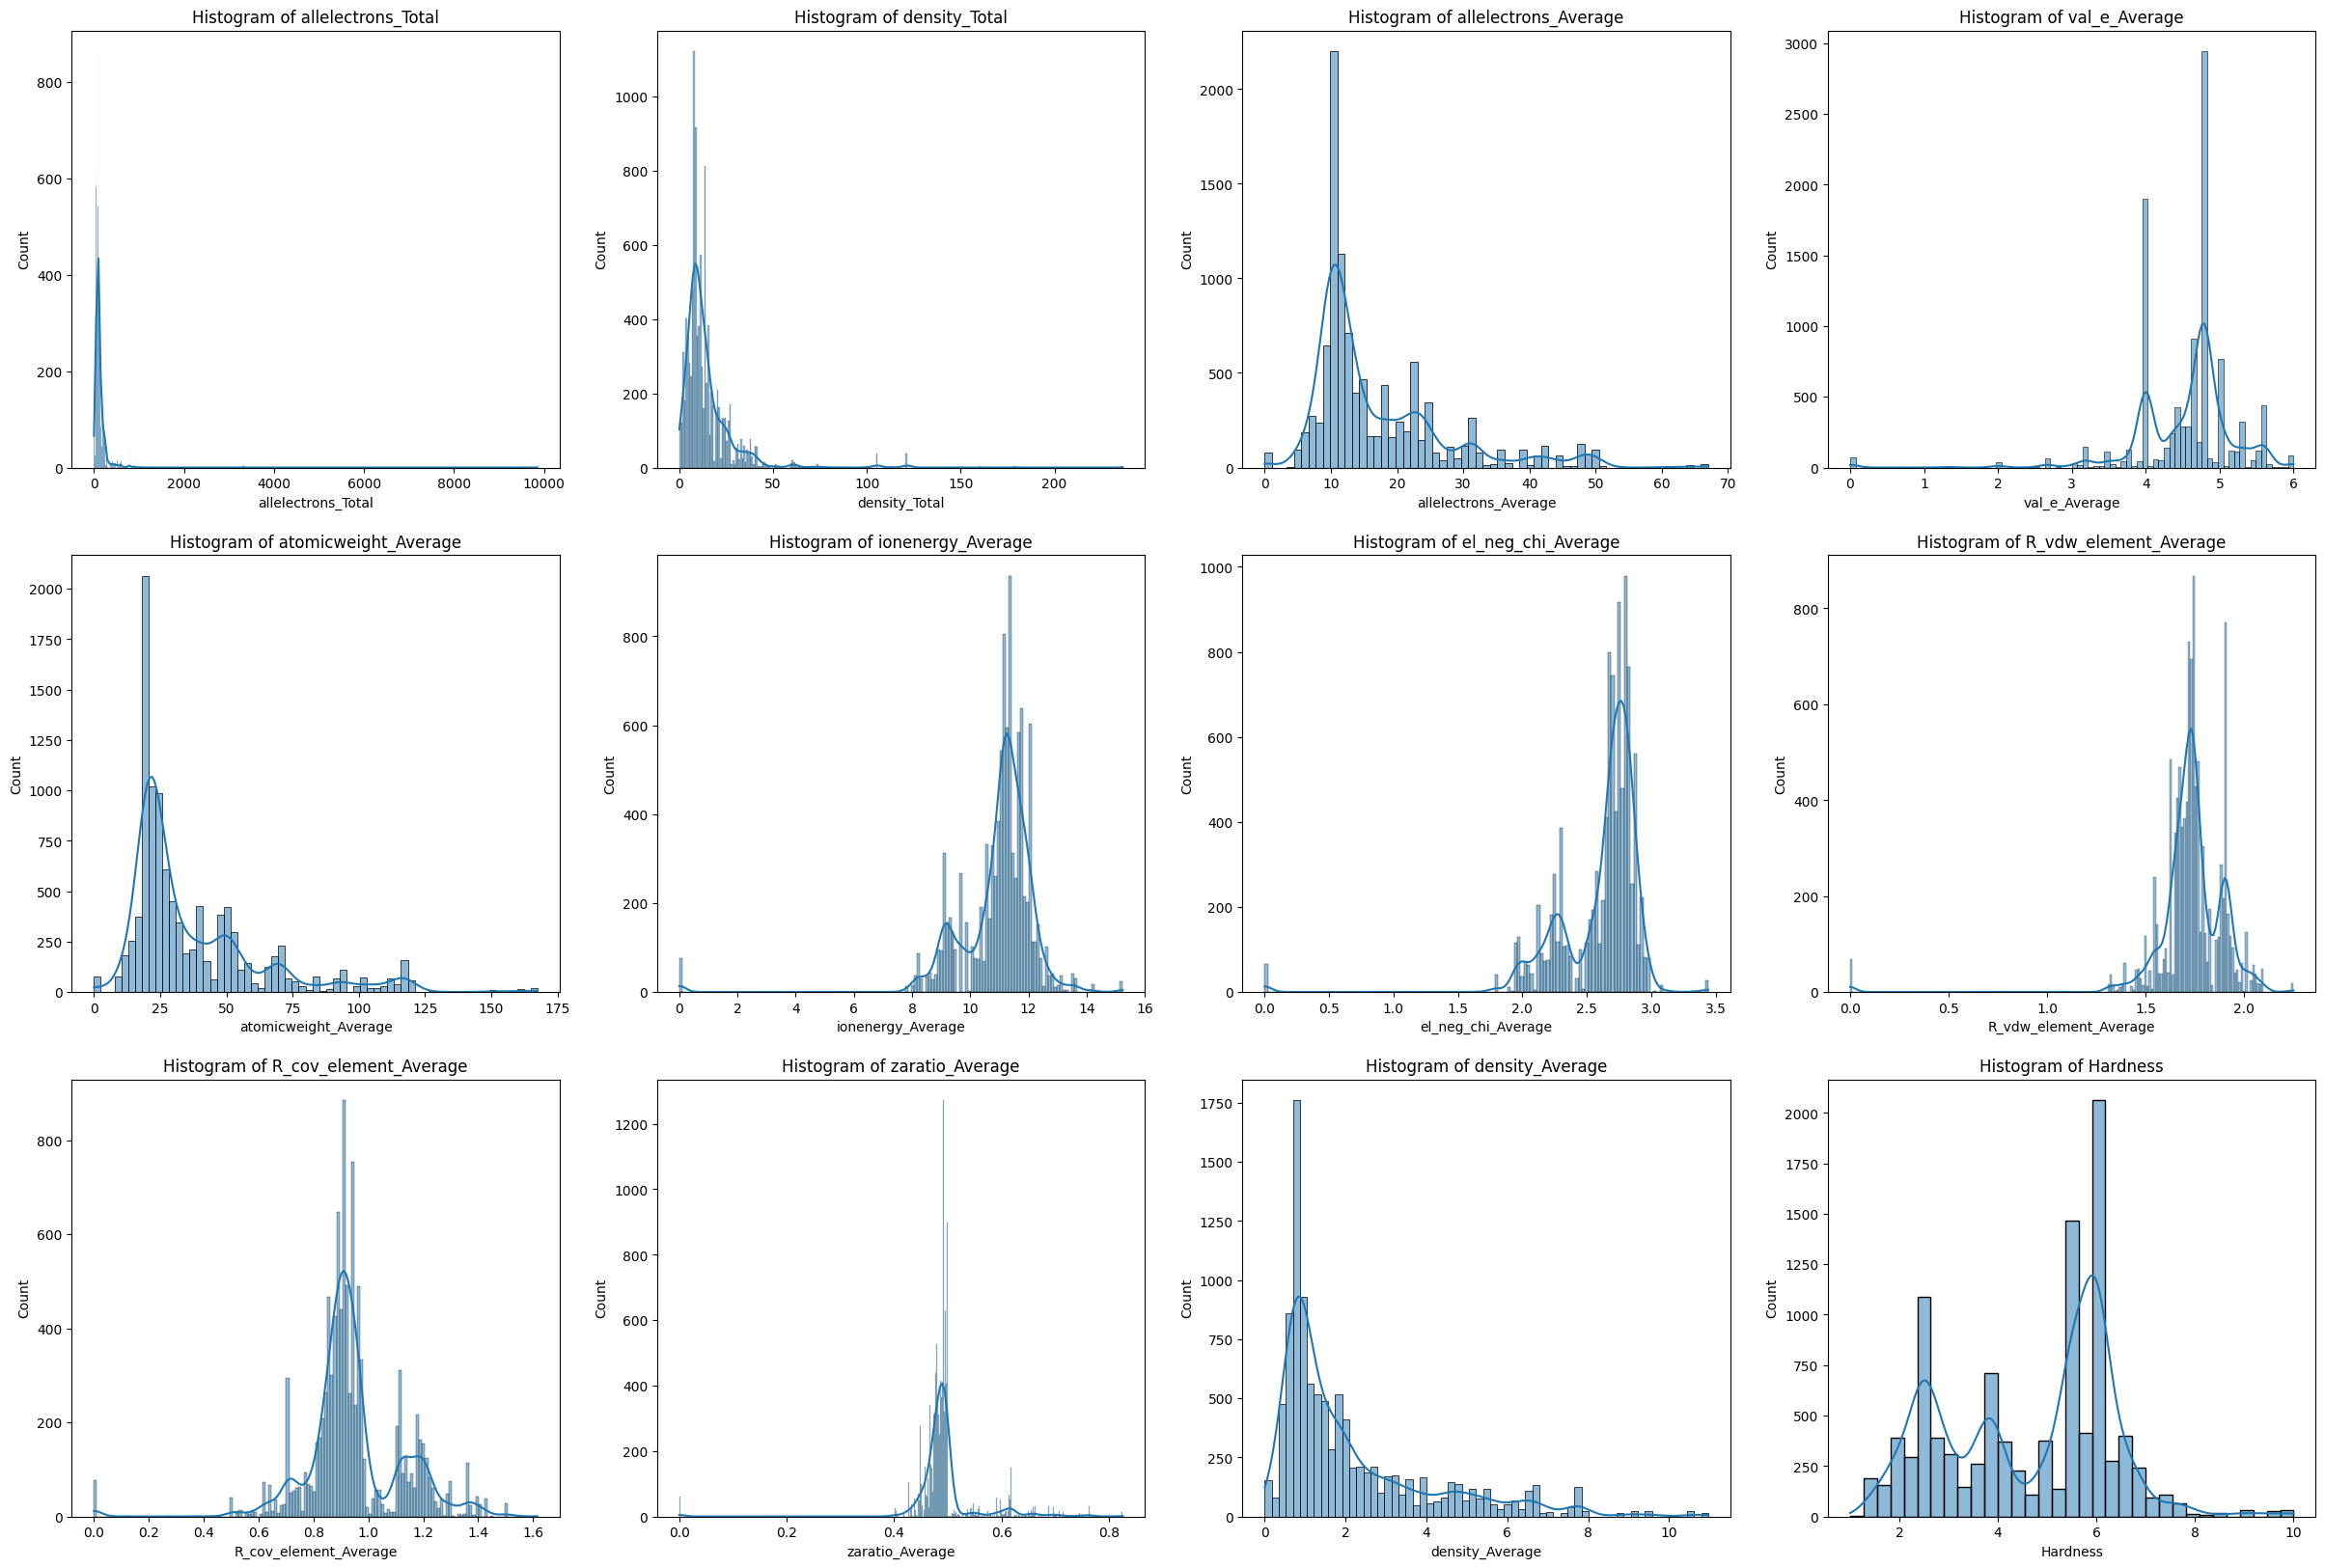

In [11]:
histogram(train, width = 30, length = 20)

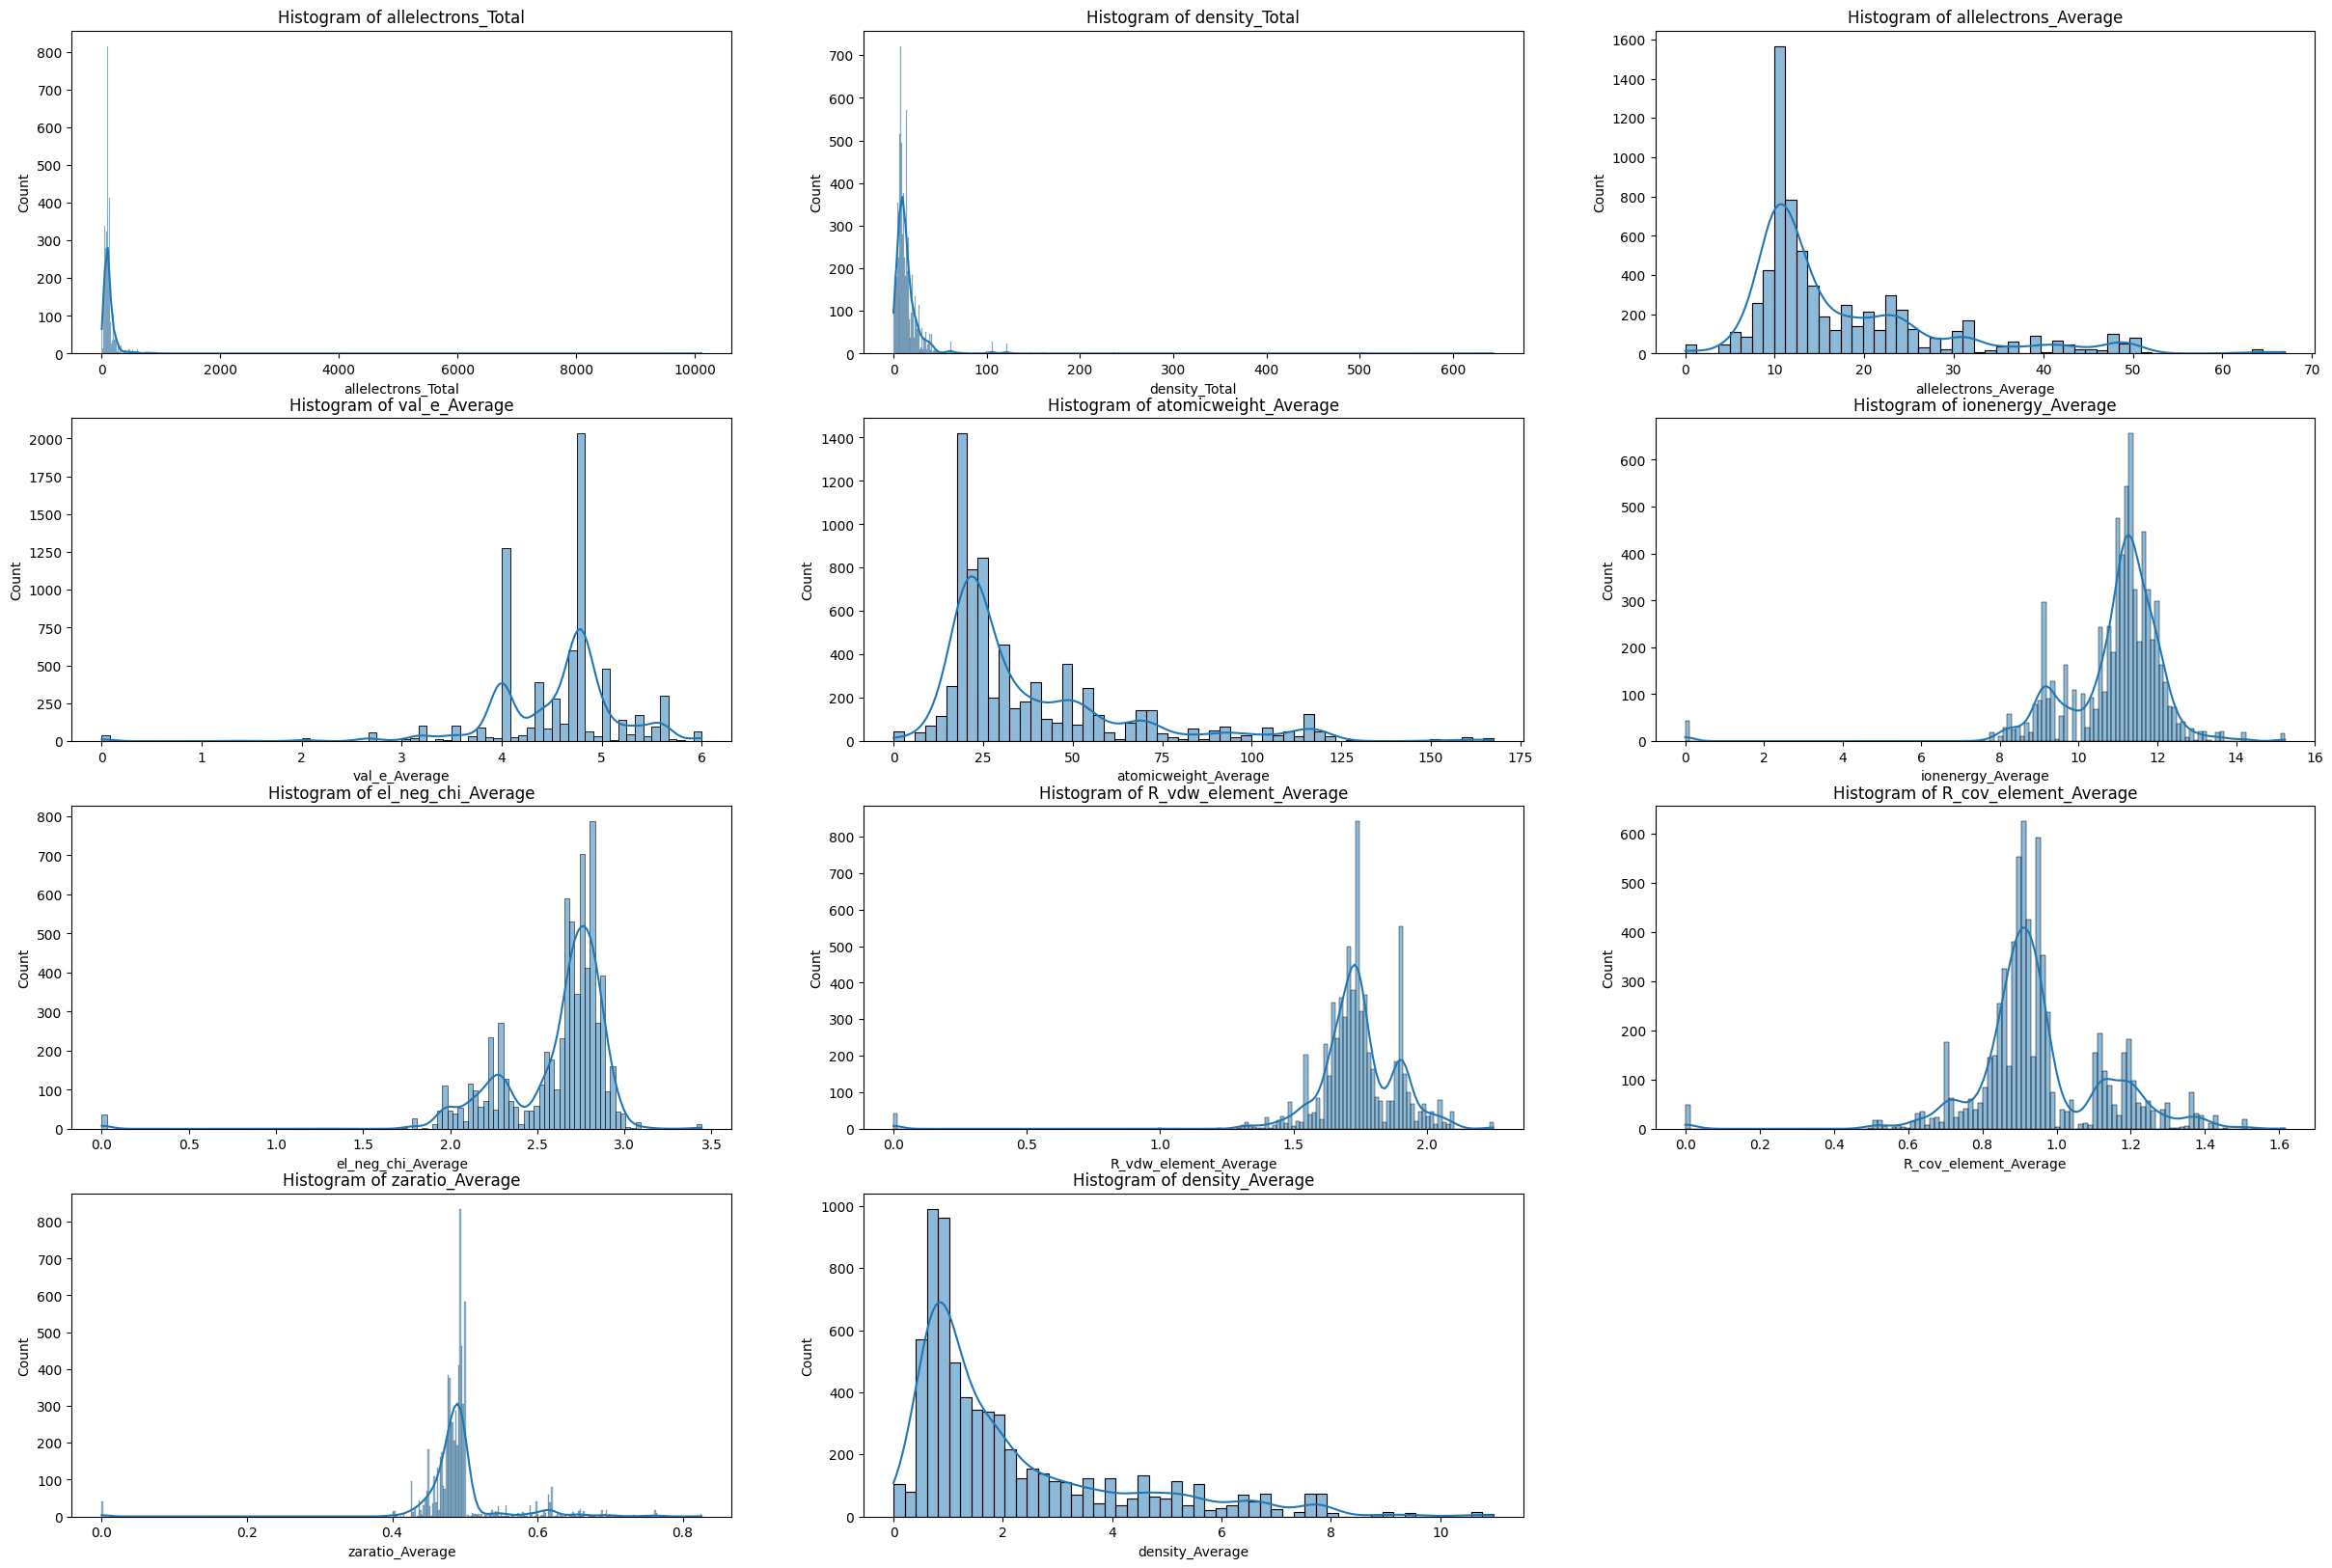

In [12]:
histogram(test, width = 30, length = 20)

The distribution between train and test dataset are similar. That is something positive, when training machine learning models, it is essential for the training set to be representative of the data the model will encounter in real-world scenarios. If the distribution in the test set closely mirrors that of the training set, it suggests that the model is being exposed to a diverse range of examples durig training, which can enhance its ability to generalize wel to new, unseen data. This alignment in distribution helps ensure that the model's performance on the test set is indicative of its potential performance in real-world applications. 

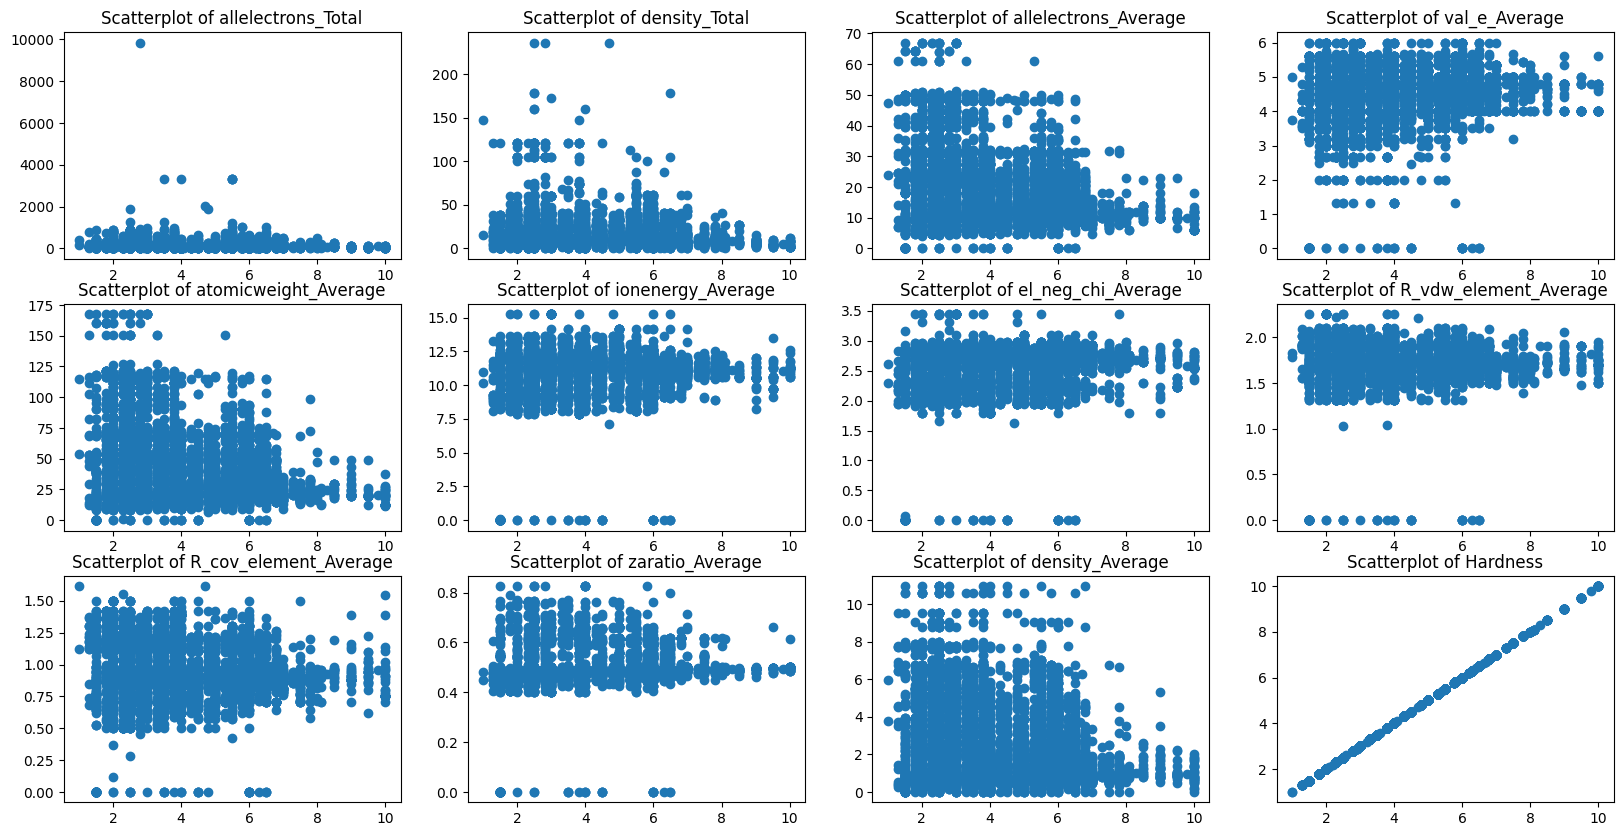

In [13]:
scatterplot(train, train["Hardness"])

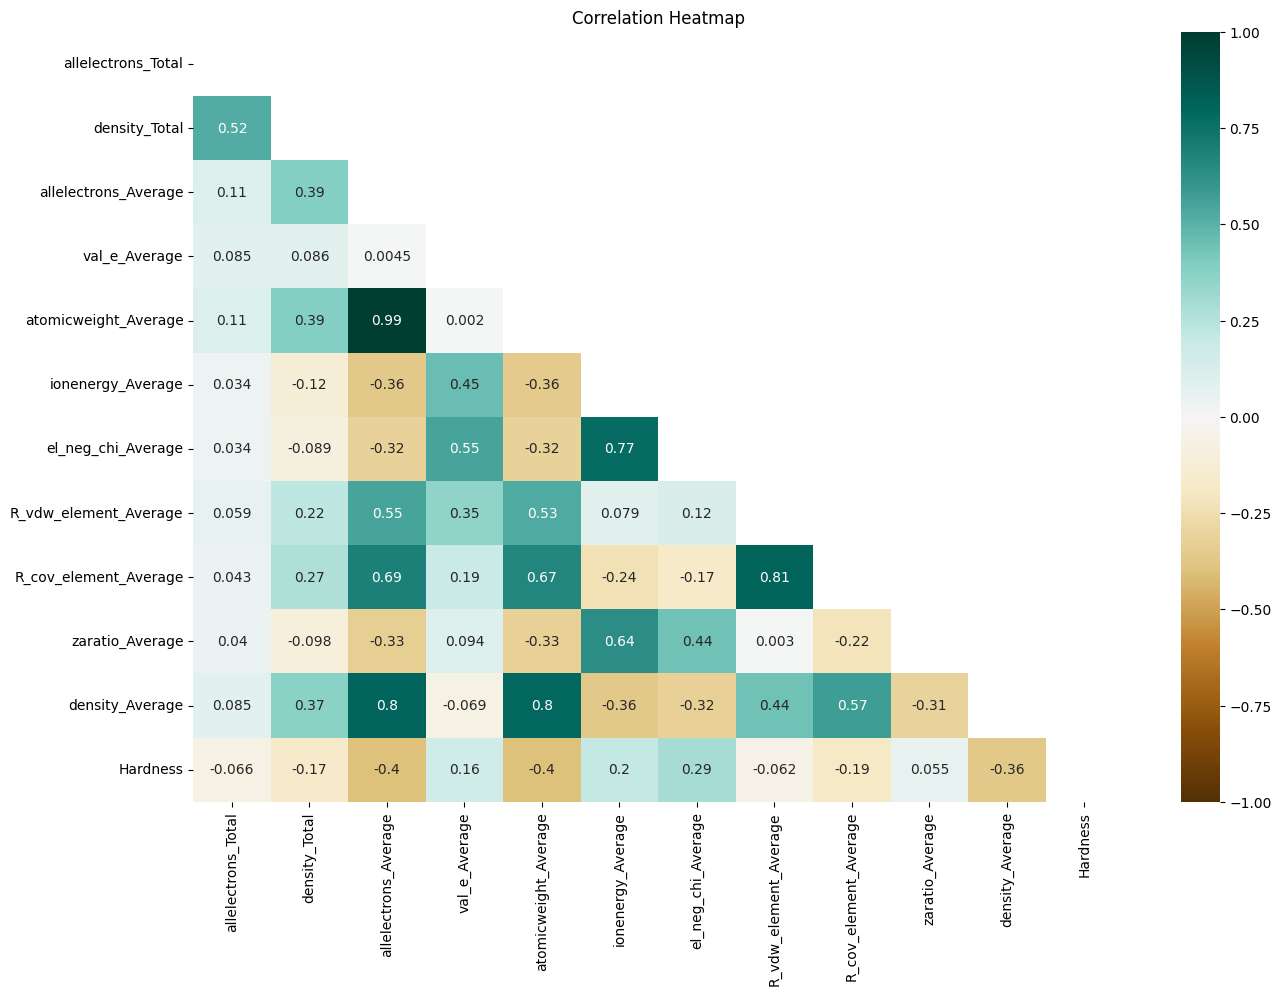

In [14]:
correlation(train, width = 15, length = 10)

**I can see that the correlation are high (above 0.8 or - 0.8) between:**

- atomicweight_Average and allelectorns_Average (0.99)
- density_Average and allelectorns_Average (0.8)
- atomicweight_Average and density_Average (0.8)
- R_vdw_element_Average and R_cov_element_Average (0.81)

**We should remove three columns: allelectorns_Average, density_Average and R_vdw_element_Average.**

In [15]:
# Cleaning testset and trainset 3
train = train.drop(columns = ["allelectrons_Average", "density_Average", "R_vdw_element_Average"])
test = test.drop(columns = ["allelectrons_Average", "density_Average", "R_vdw_element_Average"])

## Modeling (Neural Network)

In [16]:
# Normalizing the data
from sklearn.preprocessing import MinMaxScaler

X = train.drop(["Hardness"], axis = 1)
y = train["Hardness"]

scaler = MinMaxScaler()
train_normalized = scaler.fit_transform(X)
test_normalized = scaler.transform(test)

In [17]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

def loss_MedAE(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=50)

def build_model(train_data, optimizer):
    model = Sequential()
    model.add(Dense(64, activation = "relu", input_shape = (train_data.shape[1],)))
    model.add(Dense(1))
    model.compile(optimizer = optimizer, loss=loss_MedAE)
    return model

    """
    Hyperparameters that need to tune: number of layers, number of neurons per layer, activation function, learning rate.
    """
    
def tune_model(hp):
    None

def cross_validation_k_fold(X, y, n_epochs = 500, n_splits = 4, learning_rate = 0.01):
    
    history_loss, history_validation_loss, train_scores, validation_scores = [], [], [], []
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for train_index, validation_index in kf.split(X, y):
        
        optimizer = RMSprop(learning_rate=learning_rate, weight_decay = 0.001)
        
        X_train, X_validation = X[train_index], X[validation_index]
        y_train, y_validation = y.iloc[train_index], y.iloc[validation_index]
        
        model = build_model(X, optimizer)
        
        """
        In Keras, you can use the ReduceLROnPlateau callback to reduce the learning rate 
        if the validation lose does not decrease. The learning rate is reduced by a factor of 0.2 if the validation
        loss does not improve for 5 consecutive epochs. The learning rate will never be lower than 0.00001.
        """
        
        reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss", factor = 0.9, patience = 10, min_lr = 0.00001)
        
        early_stopping = EarlyStopping(monitor="val_loss", min_delta = 0.001, patience = 50)

        checkpoint = ModelCheckpoint("beste_model", monitor='val_loss', verbose=0, save_best_only=True, mode='min')
        
        history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=25,
                            validation_data=(X_validation, y_validation),verbose=0, 
                            callbacks = [reduce_learning_rate, early_stopping, checkpoint])
        
        #print(history.history.keys())
        
        train_pred = model.predict(X_train)
        validation_pred = model.predict(X_validation)
        
        train_score = median_absolute_error(y_train, train_pred)
        validation_score = median_absolute_error(y_validation, validation_pred)
        
        train_scores.append(train_score)
        validation_scores.append(validation_score)
        
        loss_history = history.history['loss']
        validation_loss_history = history.history['val_loss']
        
        history_loss.append(loss_history)
        history_validation_loss.append(validation_loss_history)
    
    print(f'\n Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | Val Score: {np.mean(validation_scores):.5f} ± {np.std(validation_scores):.5f}\n')
    
    history_loss_item = []
    history_validation_loss_item = []

    for i in range(n_epochs):
        try:
            history_loss_item.append(np.mean([x[i] for x in history_loss]))
            history_validation_loss_item.append(np.mean([x[i] for x in history_validation_loss]))
        except IndexError:
            break

    plt.figure(figsize=(20, 10))

    plt.subplot(121)
    plt.plot(range(1, len(history_loss_item) + 1), history_loss_item)
    plt.xlabel('Epochs')
    plt.ylabel('loss MedAE')
    
    plt.subplot(122)
    plt.plot(range(1, len(history_validation_loss_item) + 1), history_validation_loss_item)
    plt.xlabel('Epochs')
    plt.ylabel('Validation_loss MedAE')
    
    plt.show()
    

## Model Evaluation

82/82 [==============================] - 0s 1ms/step

 Train Score: 0.66962 ± 0.02841 | Val Score: 0.67999 ± 0.04023



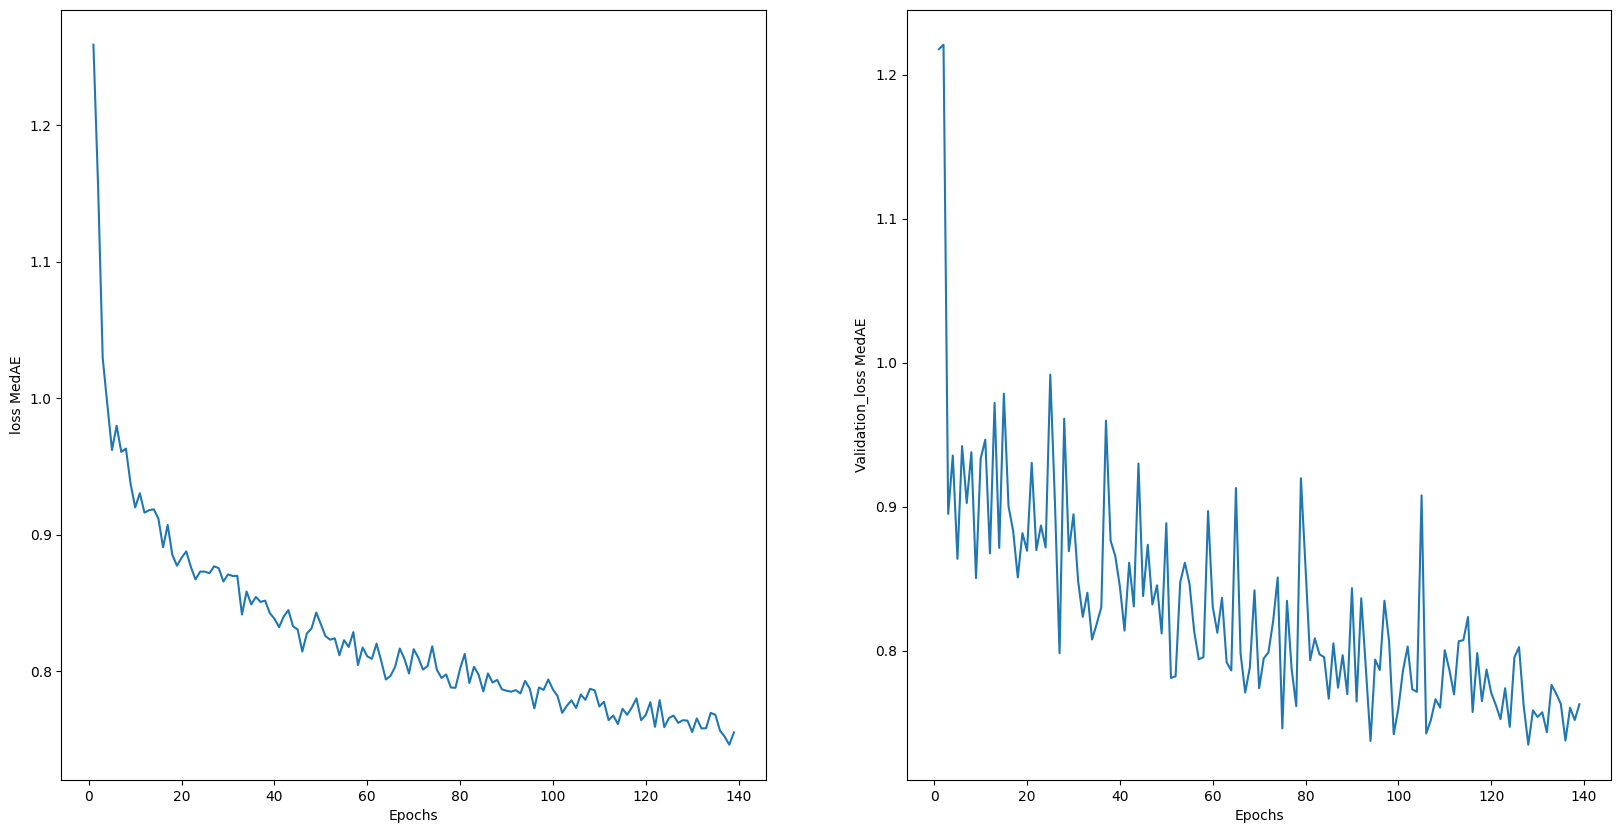

In [18]:
cross_validation_k_fold(train_normalized, y)

## Results

In [19]:
from keras.models import load_model

model = load_model('beste_model', custom_objects={'loss_MedAE': loss_MedAE})

result = model.predict(test_normalized) 

submission_id = submission['id'] 

prediction = pd.DataFrame(result, columns=['Hardness'], index=submission_id).to_csv('S13E25_NN.csv')

217/217 [==============================] - 0s 1ms/step
